<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [34]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

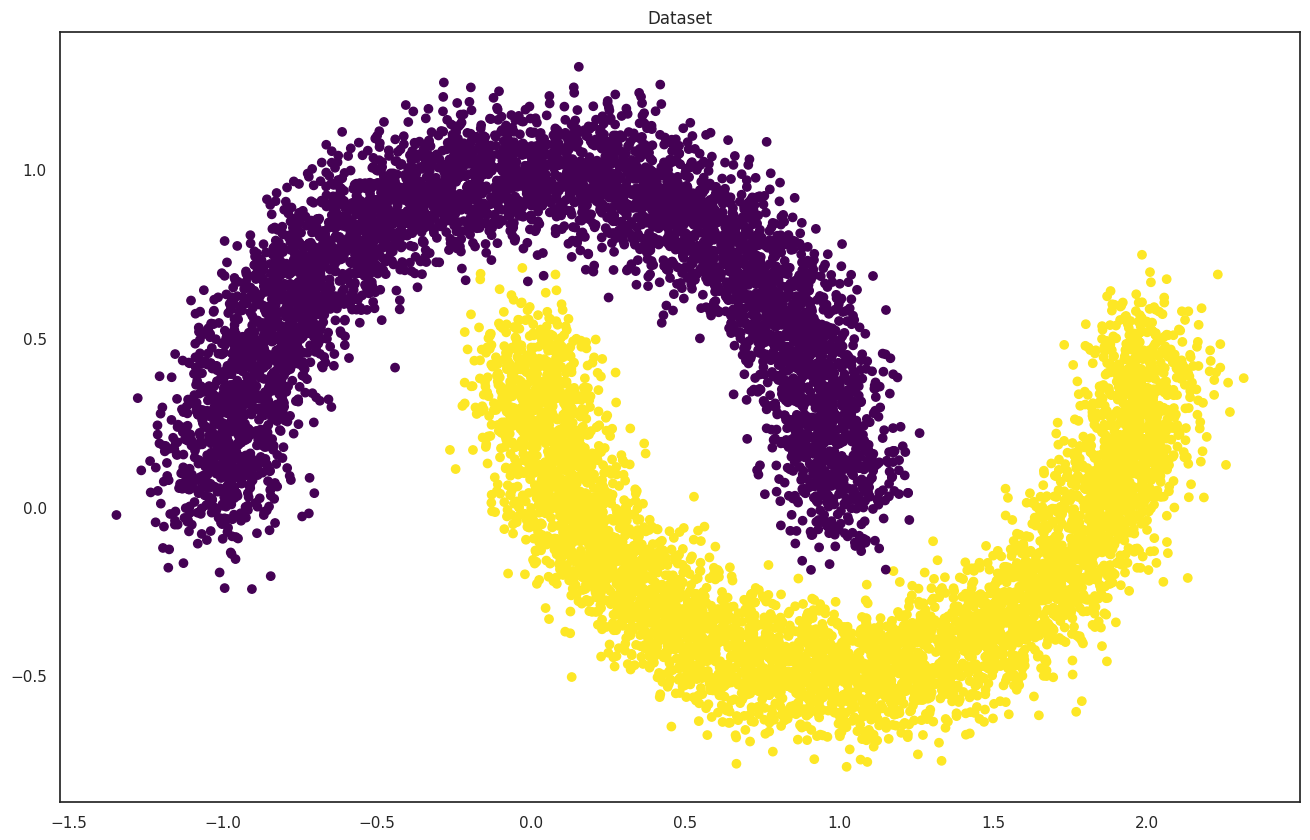

In [35]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [37]:
type(X_train), X_train.shape

(numpy.ndarray, (7500, 2))

In [38]:
X_train_t =  torch.from_numpy(X_train).to(torch.float32)
y_train_t =  torch.from_numpy(y_train).to(torch.float32)
X_val_t =  torch.from_numpy(X_val).to(torch.float32)
y_val_t =  torch.from_numpy(y_val).to(torch.float32)

Создаем `Dataset` и `DataLoader`.

In [39]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [40]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [41]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [42]:
sum = 0
for p in linear_regression.parameters():
  if p.requires_grad:
    x = p.numel()
    print(p, x)
    sum += x
print('обучаемых параметров: ', sum)

Parameter containing:
tensor([[ 0.8064],
        [-0.2895]], requires_grad=True) 2
Parameter containing:
tensor([-0.2175], requires_grad=True) 1
обучаемых параметров:  3


ОТВЕТ: 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [43]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(torch.flatten(outp), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        my_sigmoid = nn.Sigmoid()
        probabilities = my_sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.7109375
Iteration: 100
Batch accuracy: 0.78125
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.890625
Iteration: 400
Batch accuracy: 0.8671875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.8671875
Iteration: 700
Batch accuracy: 0.828125

Iteration: 755.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 755

### Визуализируем результаты

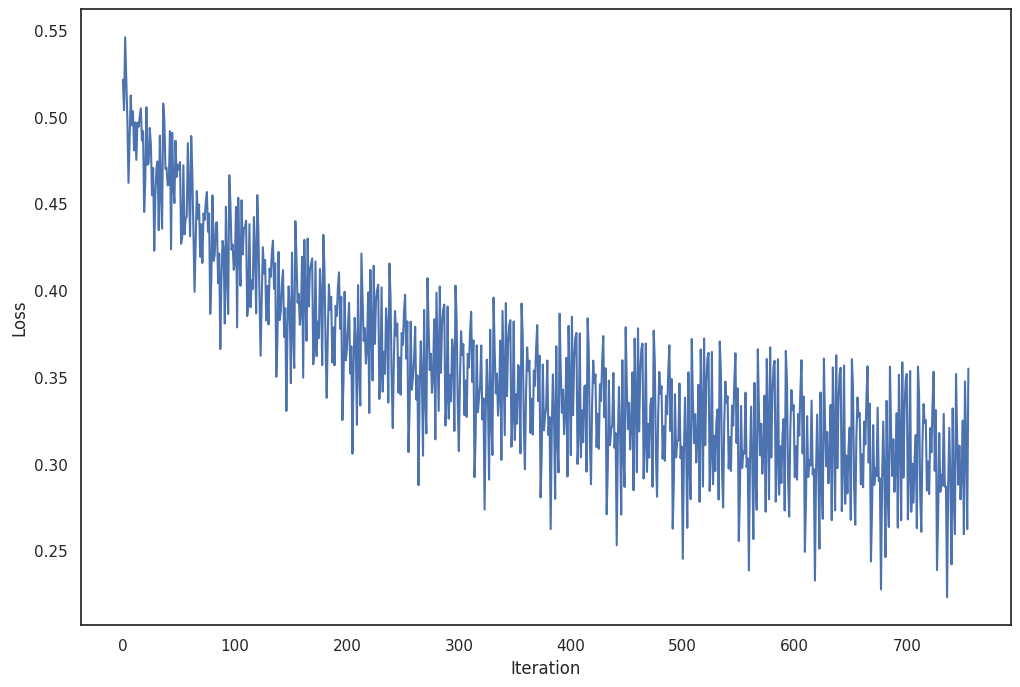

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

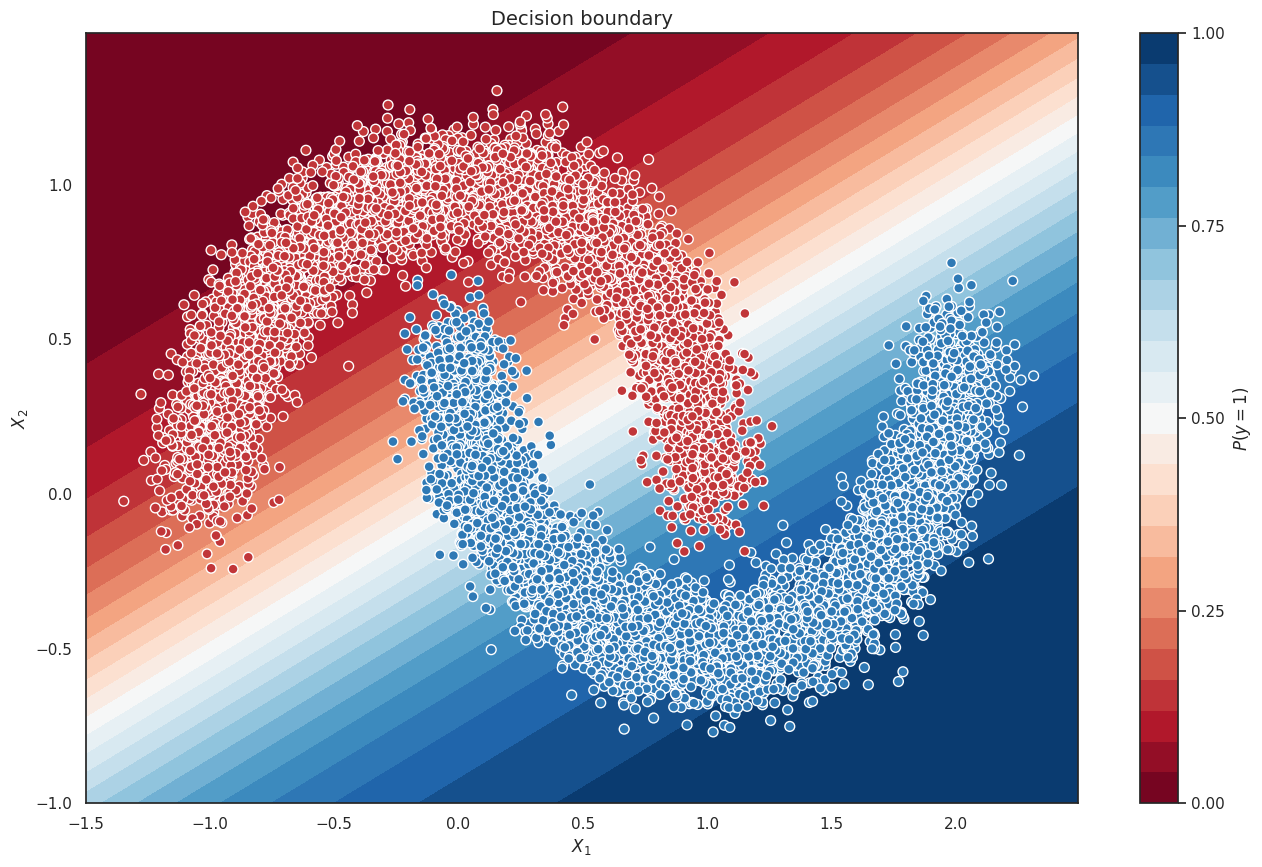

In [45]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [46]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        my_sigmoid = nn.Sigmoid()
        prob = my_sigmoid(linear_regression(x_batch))
        preds = torch.Tensor(list(map(lambda x: 1 if x >= 0.5 else 0, prob)))
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [47]:
from sklearn.metrics import accuracy_score

y_pred = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t, y_pred)

0.8612

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8612

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [57]:
import os
from torchvision import transforms as tfs
from torchvision.datasets import MNIST


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)


train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                                shuffle=True, num_workers=2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                                shuffle=False, num_workers=2)


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

In [ ]:
criterion =  torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = len([pred for i,
                          pred in enumerate(preds) if pred == y_batch[i]])
            all =  y_batch.shape[0]
            epoch_correct += correct
            epoch_all += all
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9078333333333334
Loader: valid. Accuracy: 0.949
Epoch: 2
Loader: train. Accuracy: 0.9476833333333333
Loader: valid. Accuracy: 0.9628
Epoch: 3
Loader: train. Accuracy: 0.9560666666666666
Loader: valid. Accuracy: 0.9489
Epoch: 4
Loader: train. Accuracy: 0.9606
Loader: valid. Accuracy: 0.9513
Epoch: 5
Loader: train. Accuracy: 0.9633833333333334
Loader: valid. Accuracy: 0.9505
Epoch: 6
Loader: train. Accuracy: 0.9654166666666667
Loader: valid. Accuracy: 0.9623
Epoch: 7
Loader: train. Accuracy: 0.9681666666666666
Loader: valid. Accuracy: 0.9639
Epoch: 8
Loader: train. Accuracy: 0.9688833333333333
Loader: valid. Accuracy: 0.9679
Epoch: 9
Loader: train. Accuracy: 0.9694666666666667
Loader: valid. Accuracy: 0.961
Epoch: 10
Loader: train. Accuracy: 0.9709166666666667
Loader: valid. Accuracy: 0.9633


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
elu_accuracy

[0.949, 0.9628, 0.9489, 0.9513, 0.9505, 0.9623, 0.9639, 0.9679, 0.961, 0.9633]

In [ ]:
def test_activation_function(activation):
    activation = activation()
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
    )

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                  model.train()
                  optimizer.zero_grad()
                  outp = model(x_batch)

                else:
                  model.eval()
                  with torch.no_grad():
                    outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = len([pred for i,
                              pred in enumerate(preds) if pred == y_batch[i]])
                all =  y_batch.shape[0]
                epoch_correct += correct
                epoch_all += all
                if k == "train":
                  loss = criterion(outp, y_batch)
                  loss.backward()
                  optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [ ]:
plain_accuracy = test_activation_function(Identical)
plain_accuracy

Epoch: 1
Loader: train. Accuracy: 0.8488833333333333
Loader: valid. Accuracy: 0.8837
Epoch: 2
Loader: train. Accuracy: 0.88135
Loader: valid. Accuracy: 0.8925
Epoch: 3
Loader: train. Accuracy: 0.88915
Loader: valid. Accuracy: 0.8823
Epoch: 4
Loader: train. Accuracy: 0.89275
Loader: valid. Accuracy: 0.9007
Epoch: 5
Loader: train. Accuracy: 0.89615
Loader: valid. Accuracy: 0.9108
Epoch: 6
Loader: train. Accuracy: 0.8985
Loader: valid. Accuracy: 0.8965
Epoch: 7
Loader: train. Accuracy: 0.8980833333333333
Loader: valid. Accuracy: 0.9065
Epoch: 8
Loader: train. Accuracy: 0.8999
Loader: valid. Accuracy: 0.9131
Epoch: 9
Loader: train. Accuracy: 0.901
Loader: valid. Accuracy: 0.9033
Epoch: 10
Loader: train. Accuracy: 0.9016333333333333
Loader: valid. Accuracy: 0.8898


[0.8837,
 0.8925,
 0.8823,
 0.9007,
 0.9108,
 0.8965,
 0.9065,
 0.9131,
 0.9033,
 0.8898]

In [ ]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
leaky_relu_accuracy

Epoch: 1
Loader: train. Accuracy: 0.9057333333333333
Loader: valid. Accuracy: 0.9387
Epoch: 2
Loader: train. Accuracy: 0.9448
Loader: valid. Accuracy: 0.9471
Epoch: 3
Loader: train. Accuracy: 0.9535333333333333
Loader: valid. Accuracy: 0.9513
Epoch: 4
Loader: train. Accuracy: 0.9565
Loader: valid. Accuracy: 0.9586
Epoch: 5
Loader: train. Accuracy: 0.9597666666666667
Loader: valid. Accuracy: 0.9635
Epoch: 6
Loader: train. Accuracy: 0.9623666666666667
Loader: valid. Accuracy: 0.9574
Epoch: 7
Loader: train. Accuracy: 0.9629333333333333
Loader: valid. Accuracy: 0.9478
Epoch: 8
Loader: train. Accuracy: 0.9649666666666666
Loader: valid. Accuracy: 0.9571
Epoch: 9
Loader: train. Accuracy: 0.96525
Loader: valid. Accuracy: 0.9566
Epoch: 10
Loader: train. Accuracy: 0.9674166666666667
Loader: valid. Accuracy: 0.9537


[0.9387,
 0.9471,
 0.9513,
 0.9586,
 0.9635,
 0.9574,
 0.9478,
 0.9571,
 0.9566,
 0.9537]

In [ ]:
relu_accuracy = test_activation_function(nn.ReLU)
relu_accuracy

Epoch: 1
Loader: train. Accuracy: 0.9019
Loader: valid. Accuracy: 0.9384
Epoch: 2
Loader: train. Accuracy: 0.9437833333333333
Loader: valid. Accuracy: 0.9532
Epoch: 3
Loader: train. Accuracy: 0.9516666666666667
Loader: valid. Accuracy: 0.949
Epoch: 4
Loader: train. Accuracy: 0.9554666666666667
Loader: valid. Accuracy: 0.9607
Epoch: 5
Loader: train. Accuracy: 0.9594333333333334
Loader: valid. Accuracy: 0.9581
Epoch: 6
Loader: train. Accuracy: 0.9600333333333333
Loader: valid. Accuracy: 0.9614
Epoch: 7
Loader: train. Accuracy: 0.9634333333333334
Loader: valid. Accuracy: 0.9644
Epoch: 8
Loader: train. Accuracy: 0.96375
Loader: valid. Accuracy: 0.959
Epoch: 9
Loader: train. Accuracy: 0.9647333333333333
Loader: valid. Accuracy: 0.9512
Epoch: 10
Loader: train. Accuracy: 0.9654833333333334
Loader: valid. Accuracy: 0.9648


[0.9384, 0.9532, 0.949, 0.9607, 0.9581, 0.9614, 0.9644, 0.959, 0.9512, 0.9648]

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

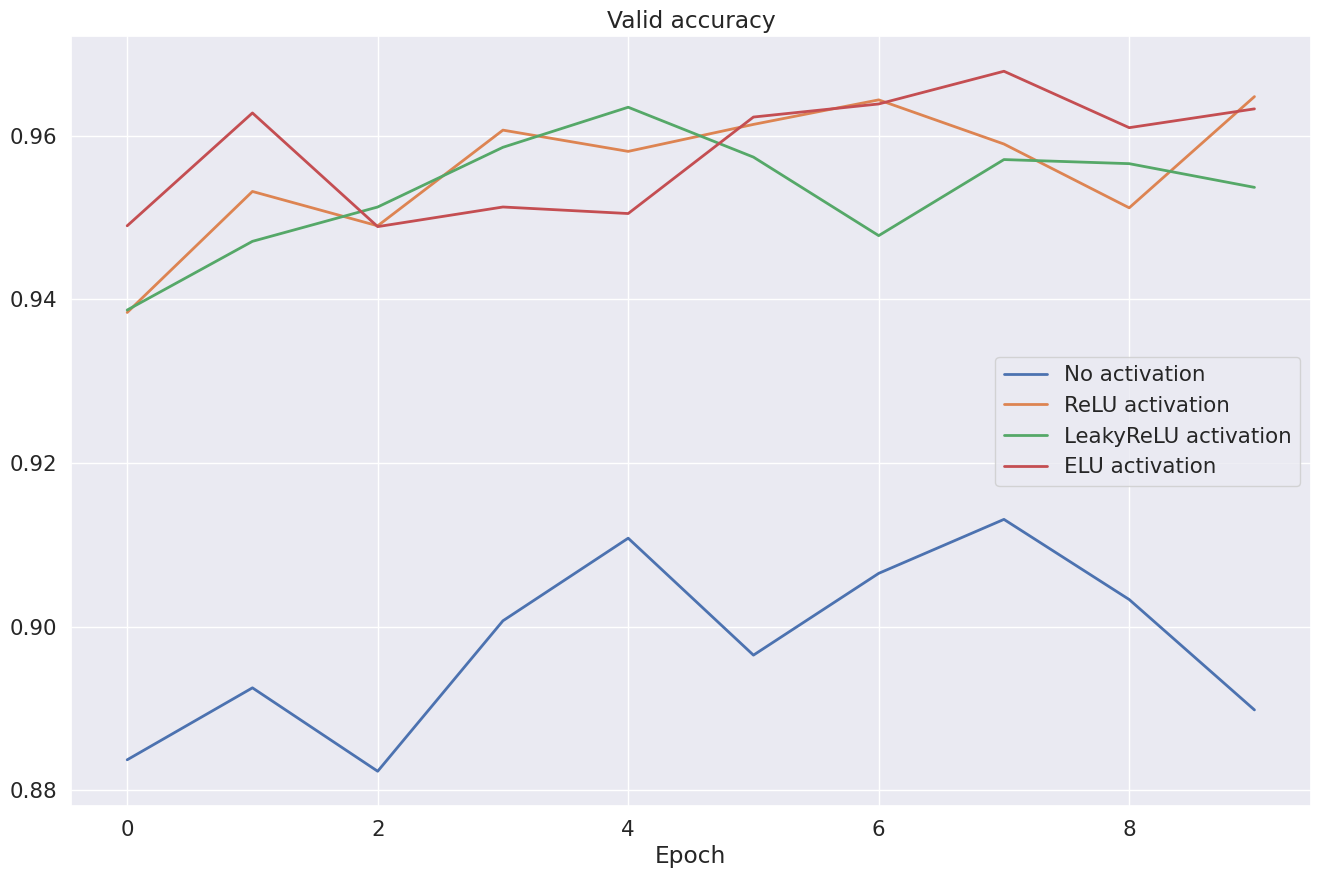

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

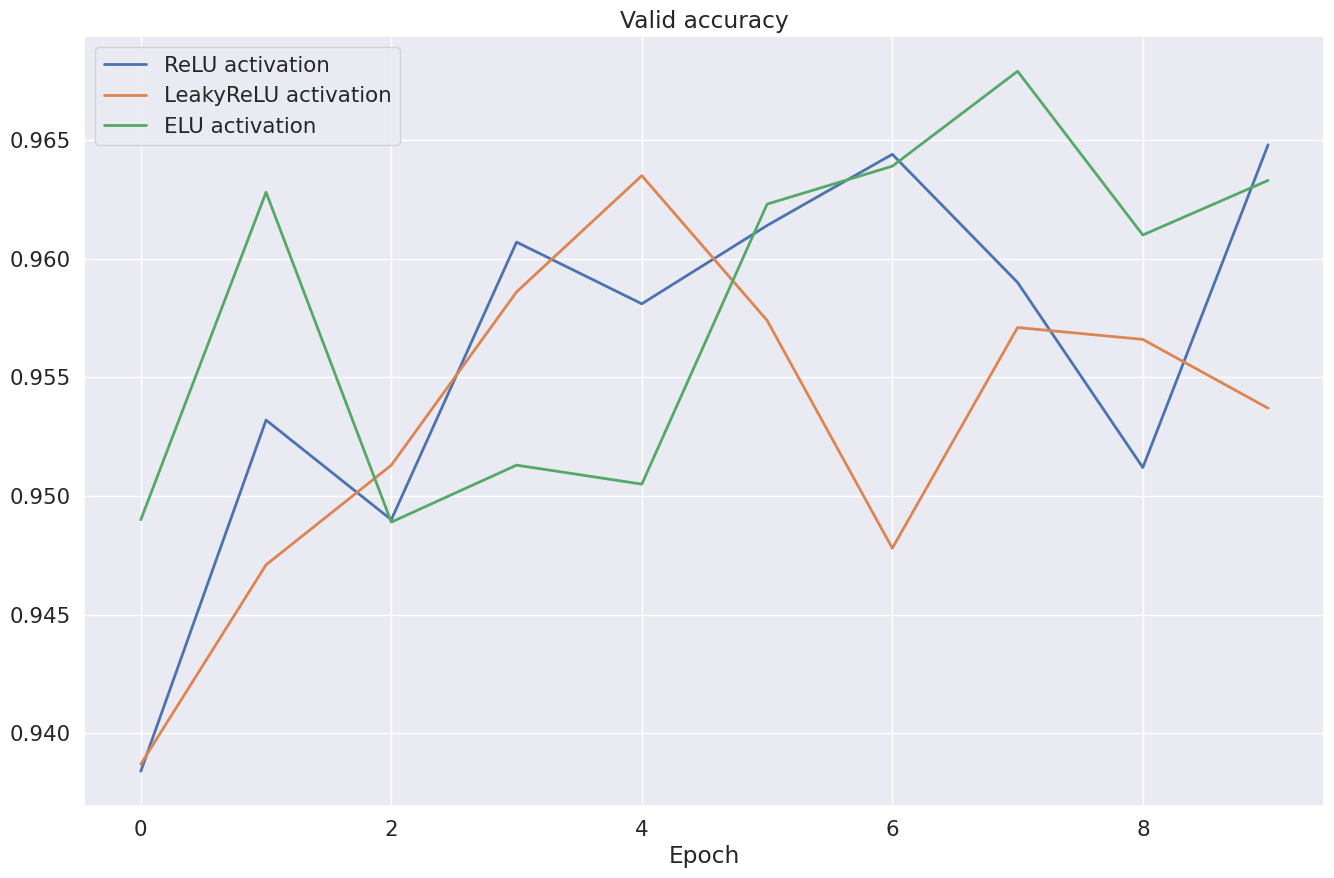

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ReLU activation. Но я предпочту использовать ELU так как в предыдущих эпахах она показывала лучшую accuracy

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [8]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-05 23:47:27--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   160KB/s    in 0.3s    

2023-11-05 23:47:27 (160 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



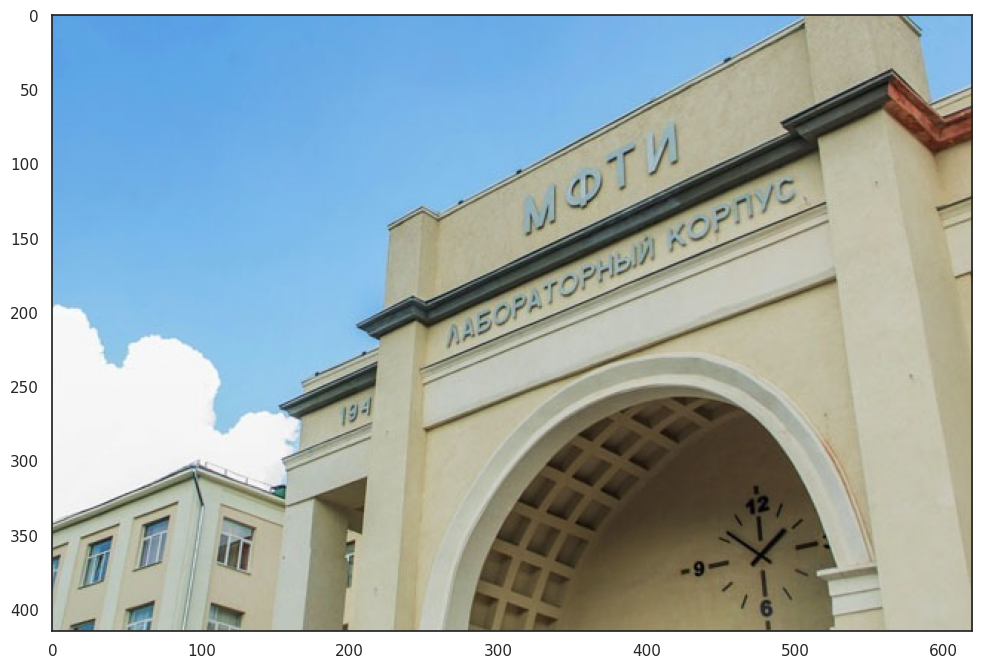

In [24]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [10]:
img

array([[[230, 160,  90],
        [230, 160,  90],
        [230, 161,  91],
        ...,
        [233, 188, 131],
        [233, 188, 131],
        [233, 188, 131]],

       [[230, 160,  90],
        [230, 160,  90],
        [230, 161,  91],
        ...,
        [234, 189, 132],
        [234, 189, 132],
        [233, 188, 131]],

       [[230, 160,  90],
        [230, 160,  90],
        [230, 161,  91],
        ...,
        [235, 190, 133],
        [234, 189, 132],
        [233, 188, 131]],

       ...,

       [[190, 198, 191],
        [190, 198, 191],
        [194, 199, 190],
        ...,
        [172, 196, 196],
        [174, 195, 196],
        [173, 194, 195]],

       [[188, 196, 189],
        [190, 199, 189],
        [197, 202, 193],
        ...,
        [172, 196, 196],
        [174, 195, 196],
        [173, 194, 195]],

       [[188, 197, 187],
        [189, 198, 188],
        [198, 203, 194],
        ...,
        [172, 196, 196],
        [173, 194, 195],
        [173, 194, 195]]

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте.   

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

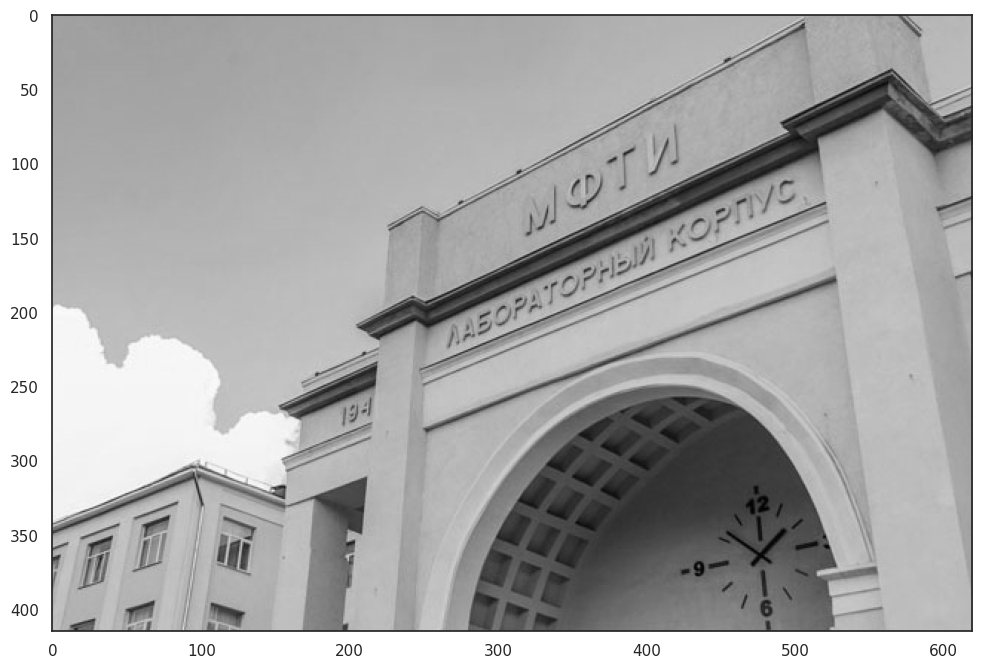

In [23]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

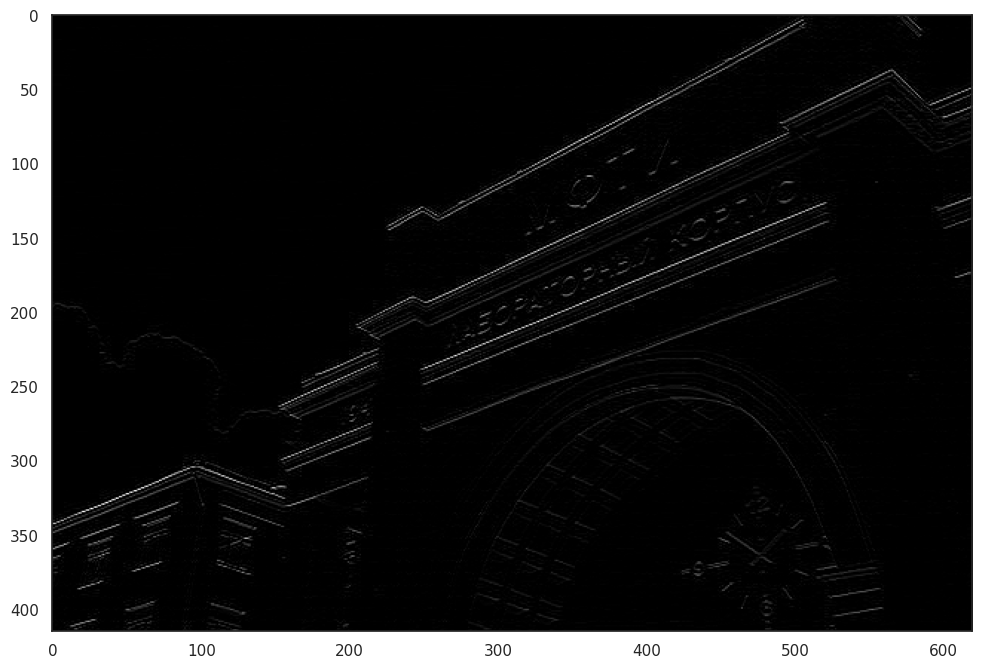

In [17]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

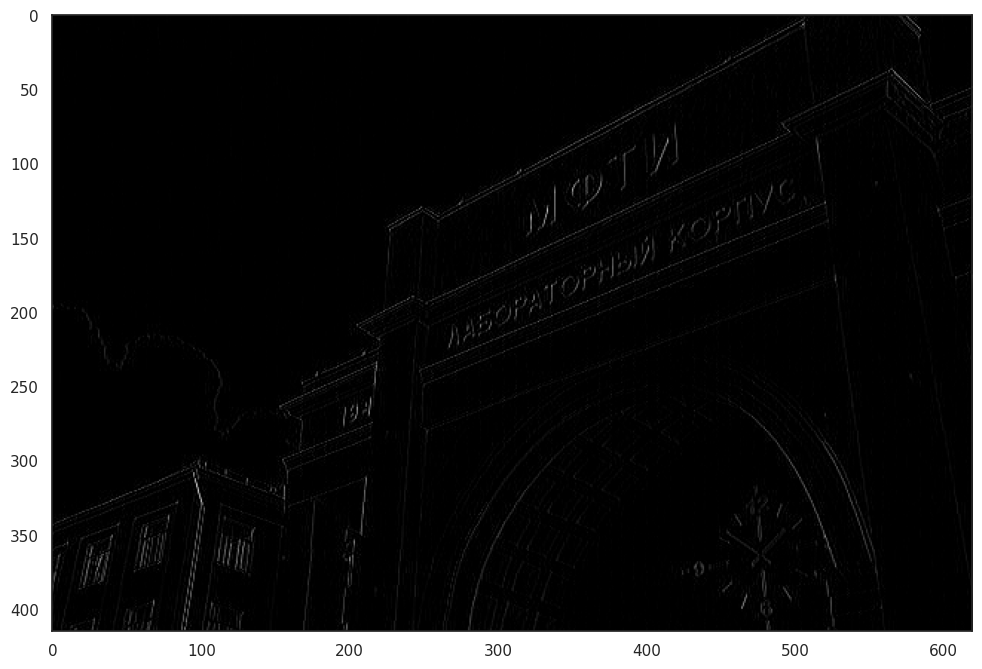

In [19]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

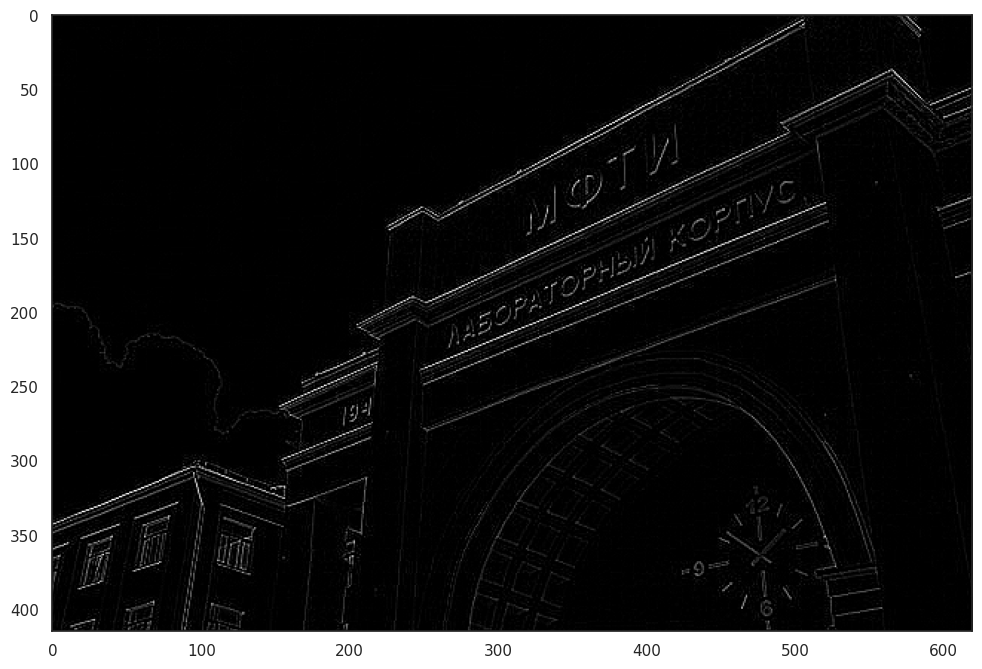

In [20]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

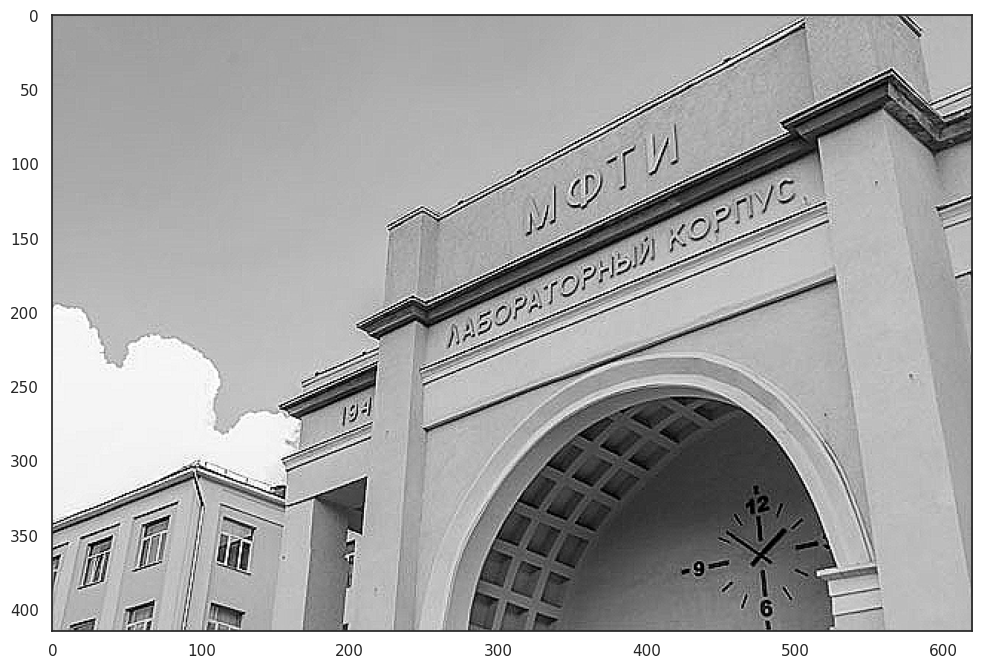

In [21]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

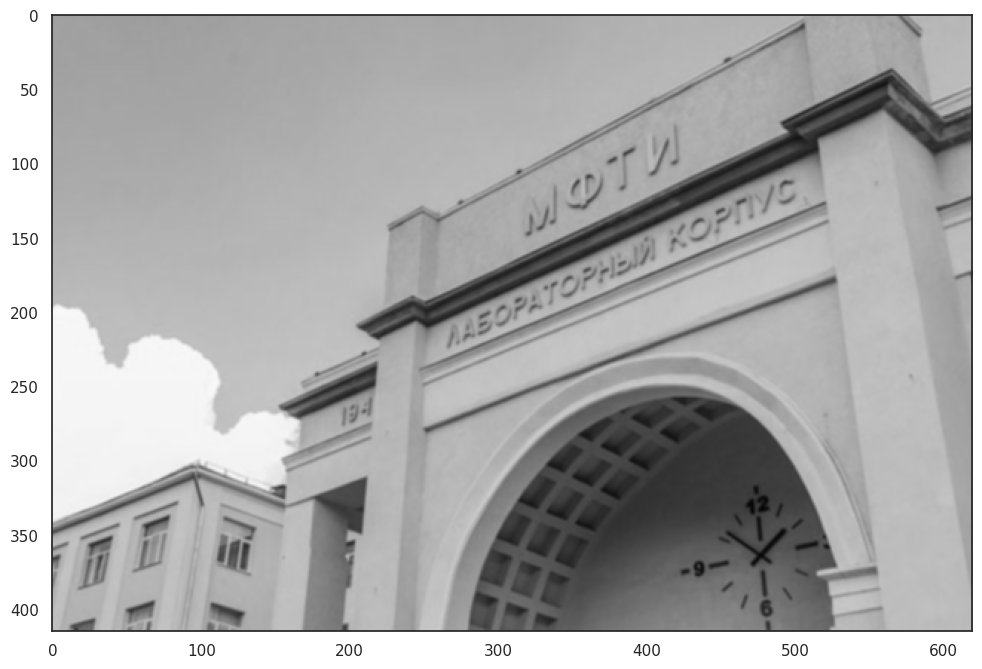

In [22]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - A

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г

**Ответ:** 1-Е, 2-Д, 3-А, 4-В, 5-Б, 6-Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [25]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)

        self.fc1 = nn.Linear(22 * 22 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 22 * 22 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

Обучим полносвязную нейронную сеть еще раз потому что не хочется ждать 1500 лет выполнения всего кода выше заново, ибо ядро было перезапущено с:  
Спасибо за понимание
Если посоветуете хорошие облачные сервисы, то будет очень круто!! А то collab из рф оплатить нельзя даже :c

In [58]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [59]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

In [60]:
criterion =  torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [61]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = len([pred for i,
                          pred in enumerate(preds) if pred == y_batch[i]])
            all =  y_batch.shape[0]
            epoch_correct += correct
            epoch_all += all
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9058
Loader: valid. Accuracy: 0.9469
Epoch: 2
Loader: train. Accuracy: 0.94715
Loader: valid. Accuracy: 0.9557
Epoch: 3
Loader: train. Accuracy: 0.9549833333333333
Loader: valid. Accuracy: 0.9565
Epoch: 4
Loader: train. Accuracy: 0.9605166666666667
Loader: valid. Accuracy: 0.9643
Epoch: 5
Loader: train. Accuracy: 0.9643
Loader: valid. Accuracy: 0.9546
Epoch: 6
Loader: train. Accuracy: 0.9654666666666667
Loader: valid. Accuracy: 0.9559
Epoch: 7
Loader: train. Accuracy: 0.9675
Loader: valid. Accuracy: 0.9654
Epoch: 8
Loader: train. Accuracy: 0.9694
Loader: valid. Accuracy: 0.9681
Epoch: 9
Loader: train. Accuracy: 0.9715333333333334
Loader: valid. Accuracy: 0.9668
Epoch: 10
Loader: train. Accuracy: 0.97165
Loader: valid. Accuracy: 0.964


### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [62]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = len([pred for i,
                          pred in enumerate(preds) if pred == y_batch[i]])
            all =  y_batch.shape[0]
            epoch_correct += correct
            epoch_all += all
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9732833333333333
Loader: valid. Accuracy: 0.9515
Epoch: 2
Loader: train. Accuracy: 0.97325
Loader: valid. Accuracy: 0.9639
Epoch: 3
Loader: train. Accuracy: 0.9742166666666666
Loader: valid. Accuracy: 0.9647
Epoch: 4
Loader: train. Accuracy: 0.9763666666666667
Loader: valid. Accuracy: 0.9634
Epoch: 5
Loader: train. Accuracy: 0.9758166666666667
Loader: valid. Accuracy: 0.9684
Epoch: 6
Loader: train. Accuracy: 0.97715
Loader: valid. Accuracy: 0.97
Epoch: 7
Loader: train. Accuracy: 0.977
Loader: valid. Accuracy: 0.9718
Epoch: 8
Loader: train. Accuracy: 0.9774666666666667
Loader: valid. Accuracy: 0.9713
Epoch: 9
Loader: train. Accuracy: 0.97785
Loader: valid. Accuracy: 0.9609
Epoch: 10
Loader: train. Accuracy: 0.9780666666666666
Loader: valid. Accuracy: 0.9679


In [67]:
lenet_accuracy = accuracy["valid"]
lenet_accuracy

[0.9515, 0.9639, 0.9647, 0.9634, 0.9684, 0.97, 0.9718, 0.9713, 0.9609, 0.9679]

In [69]:
elu_accuracy = [0.949, 0.9628, 0.9489, 0.9513, 0.9505, 0.9623, 0.9639, 0.9679, 0.961, 0.9633]
relu_accuracy = [0.9384, 0.9532, 0.949, 0.9607, 0.9581, 0.9614, 0.9644, 0.959, 0.9512, 0.9648]
leaky_relu_accuracy = [0.9387, 0.9471, 0.9513, 0.9586, 0.9635, 0.9574, 0.9478, 0.9571, 0.9566, 0.9537]

Сравним с предыдущем пунктом

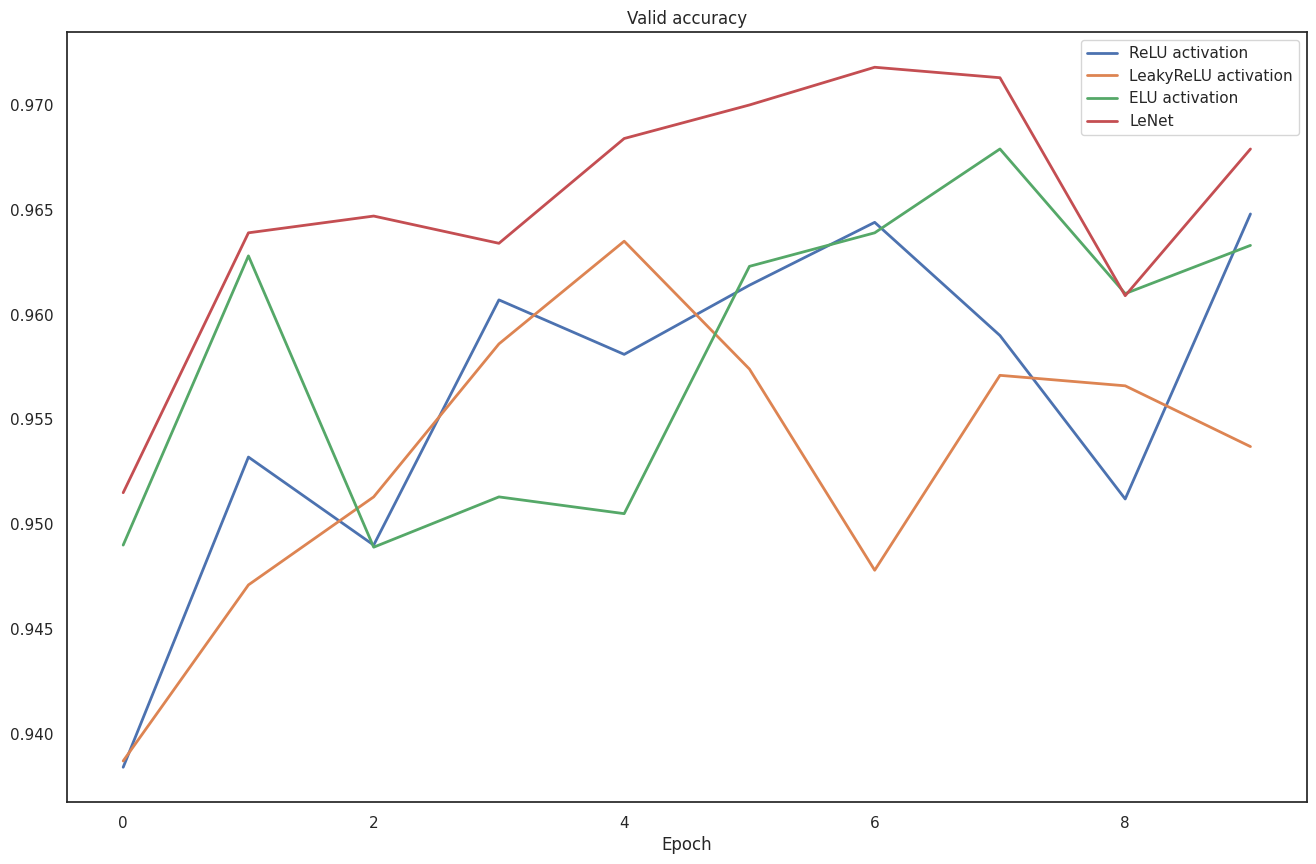

In [70]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0,97